<a href="https://colab.research.google.com/github/Pankaj-2003/LLMS-GPT/blob/main/makemore_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    # print(X)
    Y.append(ix)
    # print(Y)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [ ]:
X.shape , Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

#### Making embeddings for our 27 chars (27,2) , the paper had 27k words which they embedded in a space of 30D , but we will do 2D.
#### And our input to neural net will be indexes.
#### The weight matrix can be C , and input will be index.

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
C[X]

tensor([[[-0.1482, -0.3486],
         [-0.1482, -0.3486],
         [-0.1482, -0.3486]],

        [[-0.1482, -0.3486],
         [-0.1482, -0.3486],
         [ 1.2729,  0.2831]],

        [[-0.1482, -0.3486],
         [ 1.2729,  0.2831],
         [-1.3120,  1.7955]],

        ...,

        [[-0.8495,  0.8115],
         [-0.8495,  0.8115],
         [-1.3175,  0.6455]],

        [[-0.8495,  0.8115],
         [-1.3175,  0.6455],
         [-0.8495,  0.8115]],

        [[-1.3175,  0.6455],
         [-0.8495,  0.8115],
         [-0.4391,  0.2781]]])

In [ ]:
# embeddings for each alphabet
C = torch.randn((27,2))

In [ ]:
input = torch.randn((1,6))
weights = torch.randn((6,100))
output = input @ weights
output.shape

torch.Size([1, 100])

In [ ]:
torch.randn((1,6))
torch.randn((100,27))[0]


tensor([ 2.4426, -1.7826, -1.3188, -0.8810, -0.0038, -0.1012, -0.0351, -1.6199,
         0.7342, -0.5516,  0.8812, -0.6778, -0.7437,  0.1506, -1.1346,  0.7709,
         0.4560, -1.0686,  1.9880, -1.0703,  0.3448, -0.4128, -0.9942,  1.1625,
        -0.3947,  0.7453,  1.0583])

In [70]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) # 6 input size and 200 is the no of neurons in the hidden layer
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
W1

tensor([[ 6.1690e-01,  1.5160e+00,  2.4720e-01,  ...,  8.2253e-01,
          1.7068e+00,  6.7033e-02],
        [-2.2439e-01,  5.1658e-01, -9.4188e-01,  ..., -8.0919e-02,
         -2.5415e-01, -1.2758e-03],
        [ 1.6293e-01,  1.3413e+00,  1.2230e+00,  ...,  1.1552e-01,
         -1.2586e+00, -6.3704e-01],
        [-1.1634e+00, -1.3736e+00,  2.0308e+00,  ..., -2.7284e-01,
          2.5866e+00,  1.5013e-01],
        [ 2.4152e+00, -8.0001e-01, -2.1576e+00,  ...,  9.1956e-01,
          4.7423e-01,  1.2412e+00],
        [-1.2105e+00, -6.7169e-01,  1.8426e-01,  ..., -1.4425e+00,
          2.5825e-01,  2.1147e+00]])

In [ ]:
lre = torch.linspace(-3 , 0 , 1000)
lrs = 10**lre

In [71]:
lri = []
lossi = []
stepi  = []

In [81]:

# training neural net

# forward pass
for p in parameters:
  p.requires_grad = True

for k in range(200000):
  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (32,))
  X_b = Xtr[ix]
  Y_b = Ytr[ix]
  # forward pass
  emb_x = C[X_b]  # (32, 3 , 2)
  h = torch.tanh(emb_x.view(-1,30) @ W1 + b1)   # (32,100)

  logits = h @ W2 + b2   # (32,27)
  loss = F.cross_entropy(logits, Y_b)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  # lr = lrs[k]

  lr = 0.1 if k < 100000 else 0.01
  # update
  for p in parameters:
    p.data += -lr * p.grad
  # track
  # lri.append(lre[k])

  lossi.append(loss.log10().item())
  stepi.append(k)

print(loss.item())

1.9837089776992798


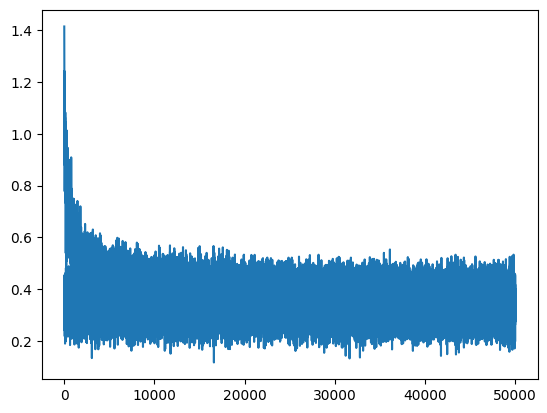

In [67]:

plt.plot(stepi , lossi)

In [68]:
# training split for parameters w and b , validation split  this for hyperparameters  , test split
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss





tensor(2.1609, grad_fn=<NllLossBackward0>)

In [69]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1883, grad_fn=<NllLossBackward0>)

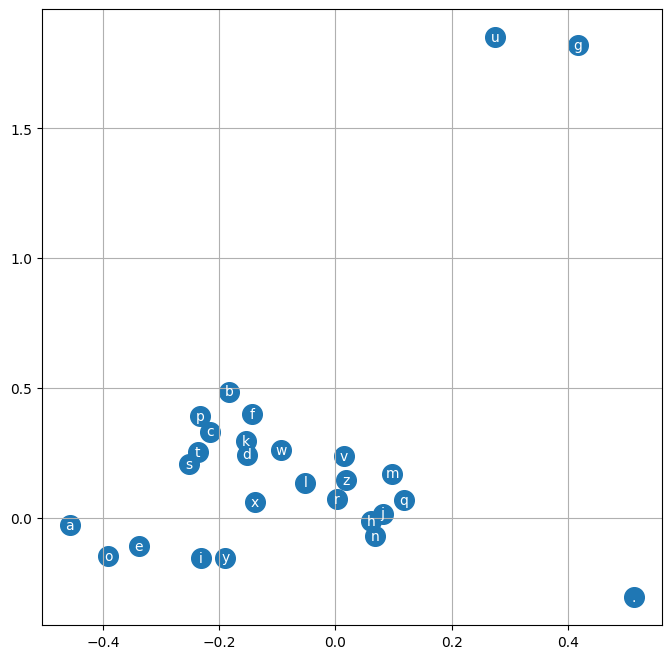

In [34]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# we see model is underfitting that means it has high bias , and is not able to learn underlying pattern in data , this happens if the model is too simple which i have dealt with ,
# by increasing the hidden layer size from 100 to 300 and other reason can be no of insufficient features in the training data or too less parameters in the model ,
# by increasing the size of embedding layer we can make the model more complex by adding more learnable parameters ,because  A larger embedding can capture more nuanced relationships between characters.


In [82]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nduriah.
remmadieja.
leg.
azee.
daeliianni.
jen.
eden.
van.
nar.
elyzion.
kasin.
shabergshiriel.
jacie.
jennex.
thana.
ubelled.
ryyah.
